# Understanding Cross Entroy Loss in Pytorch

[Cross entropy loss][1] is defined as $-{(y\log(p) + (1 - y)\log(1 - p))}$ where $y$ is the target and $p$ is the predicted value. Andrew Ng's machine-learning course (Lecture 6.4 Logistic Regression Cost Function) explains it well and can still be found, unofficially.

I was trying to get Pytorch to compute per-pixel cross entropy loss for training an image segmentation task with [UNet][2]. I managed to get very confused, so let's sort it out.

[1]: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy
[2]: https://www.youtube.com/watch?v=u1loyDCoGbE

In [1]:
import torch

## The wrong way

Let's say my the classes of my pixels on a 10x10 image are all zeros. I guess all ones. Can't get much more wrong than that. And, my loss is...

In [2]:
y = torch.zeros((10,10))
p = torch.ones((10,10), dtype=torch.float32)

loss = torch.nn.CrossEntropyLoss()
loss(p, y)

tensor(-0.)

Zero? Seems a bit off. OK, let's say the truth is all ones and I guess all ones. Should be perfect.

In [3]:
y = torch.ones((10,10))
p = torch.ones((10,10), dtype=torch.float32)

loss = torch.nn.CrossEntropyLoss()
loss(p, y)

tensor(23.0259)

Now you're pissing me off.

## BCE loss

Well, to cut to the punch line, what I want here is [BCELoss][3] (binary cross entropy loss), as opposed to [CrossEntropyLoss][4] which is really **multiclass** cross entropy loss.

[3]: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
[4]: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [4]:
y = torch.ones((10,10))
p = torch.ones((10,10), dtype=torch.float32)

loss = torch.nn.BCELoss()
loss(p, y)

tensor(0.)

In [5]:
y = torch.zeros((10,10))
p = torch.ones((10,10), dtype=torch.float32)

loss = torch.nn.BCELoss()
loss(p, y)

tensor(100.)

OK, sanity restored. Why 100, by the way? “BCELoss clamps its log function outputs to be greater than or equal to -100. This way, we can always have a finite loss value and a linear backward method.”

## Working it out

OK, but let's make sure we understand what's going on. Maybe, I've forgotten how cross entropy works. Let's implement $-{(y\log(p) + (1 - y)\log(1 - p))}$. Since taking log of zero is annoyingly undefined, we'll try to approximate Pytorch's clamping behaviour using an epsilon that we'll set at $e^{-100}$.

In [6]:
def cross_entropy(pred, target, epsilon=torch.exp(torch.tensor([-100]))):
    return - target * torch.log(pred.clip(min=epsilon)) - (1-target) * torch.log((1-pred).clip(min=epsilon))

In [7]:
pred = torch.tensor([0, 1, 0, 1, 0.2, 0.5, 0.8, 0.9])
target = torch.tensor([0, 0, 1, 1, 1,   1,   1,   1  ])
loss = cross_entropy( pred, target )

print(", ".join(f"{x:0.4f}" for x in loss))

-0.0000, 99.9831, 99.9831, 0.0000, 1.6094, 0.6931, 0.2231, 0.1054


This seems right. High values when we're wrong. Low values when we're close. Zero when we got it right.

But, a pixel's worth a thousand element vector. Let's draw.

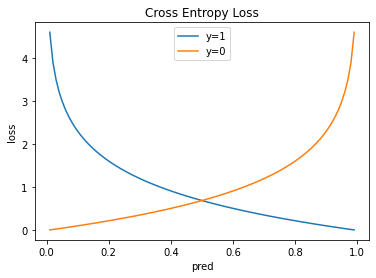

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

x = torch.linspace(0.01, 0.99, 99)
y = cross_entropy(x, torch.ones((99)))
plt.plot(x,y)

y = cross_entropy(x, torch.zeros((99)))
plt.plot(x,y)

plt.xlabel("pred")
plt.ylabel("loss")
plt.legend(["y=1", "y=0"])
plt.title("Cross Entropy Loss")
plt.show()

## CrossEntropyLoss

So, let's try to do that with torch's CrossEntropyLoss. The shapes it wants are:

$\text{pred:} (b, C, d_1, d_2, ..., d_k)$ where b=minibatch size, C is the number of classes, and elements are unnormalized scores.

$\text{target:} (b, d_1, d_2, ..., d_k)$ where the elements are integers in \[0, (C-1)\].


In [9]:
loss = torch.nn.CrossEntropyLoss(reduction="none")

pred =  torch.tensor([[1,0], [0,1], [1,0], [0,1], [0.8, 0.2], [0.5,0.5], [0.2,0.8], [0.1,0.9]], dtype=torch.float32)
label = torch.tensor([ 0,     0,       1,     1,        1,         1,         1,         1   ], dtype=torch.long)

loss = loss(pred, label)
loss

tensor([0.3133, 1.3133, 1.3133, 0.3133, 1.0375, 0.6931, 0.4375, 0.3711])

I wasn't expecting the unnormalized part, so that threw me a bit. I realized, what it's doing isn't this:

In [10]:
pred = torch.tensor([0, 1, 0, 1, 0.2, 0.5, 0.8, 0.9])
target = torch.tensor([0, 0, 1, 1, 1,   1,   1,   1  ])
loss = cross_entropy( pred, target )

print(", ".join(f"{x:0.4f}" for x in loss))

-0.0000, 99.9831, 99.9831, 0.0000, 1.6094, 0.6931, 0.2231, 0.1054


Torch is doing some kind of rescaling and then squashing with a sigmoid function.

In [11]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

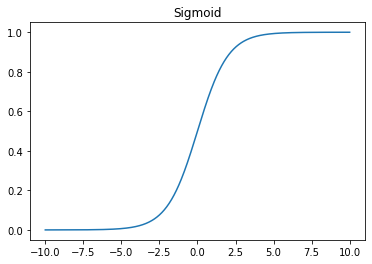

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

x = torch.linspace(-10, 10, 500)
y = sigmoid(x)
plt.plot(x,y)
plt.title("Sigmoid")
plt.show()

In [13]:
def center(x, center_at=0):
    return x - (x.max()-x.min())/2 + center_at

In [14]:
def rescale(x, lo=-1, hi=1):
    return (x-x.min()) / (x.max()-x.min()) * (hi-lo) + lo

In [15]:
pred = torch.tensor([0, 1, 0, 1, 0.2, 0.5, 0.8, 0.9])
target = torch.tensor([0, 0, 1, 1, 1,   1,   1,   1  ])
loss = cross_entropy(sigmoid(rescale(pred)), target )
print(", ".join(f"{x:0.4f}" for x in loss))

0.3133, 1.3133, 1.3133, 0.3133, 1.0375, 0.6931, 0.4375, 0.3711


In [16]:
loss = torch.nn.CrossEntropyLoss(reduction="none")

pred =  torch.tensor([[1,0], [0,1], [1,0], [0,1], [0.8, 0.2], [0.5,0.5], [0.2,0.8], [0.1,0.9]], dtype=torch.float32)
label = torch.tensor([ 0,     0,       1,     1,        1,         1,         1,         1   ], dtype=torch.long)

loss = loss(pred, label)
loss

tensor([0.3133, 1.3133, 1.3133, 0.3133, 1.0375, 0.6931, 0.4375, 0.3711])

In [17]:
pred = torch.tensor([0, 1, 0, 1, 0.2, 0.5, 0.8, 0.9])*10
target = torch.tensor([0, 0, 1, 1, 1,   1,   1,   1  ])
loss = cross_entropy(sigmoid(rescale(pred, lo=-10, hi=10)), target )
print(", ".join(f"{x:0.4f}" for x in loss))

0.0000, 9.9996, 10.0000, 0.0000, 6.0025, 0.6931, 0.0025, 0.0003


In [18]:
loss = torch.nn.CrossEntropyLoss(reduction="none")

pred =  torch.tensor([[1,0], [0,1], [1,0], [0,1], [0.8, 0.2], [0.5,0.5], [0.2,0.8], [0.1,0.9]], dtype=torch.float32)*10
label = torch.tensor([ 0,     0,       1,     1,        1,         1,         1,         1   ], dtype=torch.long)

loss = loss(pred, label)
loss

tensor([4.5418e-05, 1.0000e+01, 1.0000e+01, 4.5418e-05, 6.0025e+00, 6.9315e-01,
        2.4757e-03, 3.3540e-04])

## Per-pixel cross-entropy loss

Knowing all that, can we make the original per-pixel case work using multiclass CrossEntropyLoss?

In [19]:
y = torch.ones((10,10), dtype=torch.long).unsqueeze(0)
print(y.shape)
p = torch.stack((
        torch.zeros((10,10), dtype=torch.float32),
        torch.ones((10,10), dtype=torch.float32)*40
)).unsqueeze(0)
print(p.shape)

loss = torch.nn.CrossEntropyLoss()
loss(p, y)

torch.Size([1, 10, 10])
torch.Size([1, 2, 10, 10])


tensor(0.)

In [20]:
y = torch.zeros((10,10), dtype=torch.long).unsqueeze(0)
print(f"{y.shape=}")

p = torch.stack((
        torch.zeros((10,10), dtype=torch.float32),
        torch.ones((10,10), dtype=torch.float32)*10
)).unsqueeze(0)
print(f"{p.shape=}")

loss = torch.nn.CrossEntropyLoss()
loss(p, y)

y.shape=torch.Size([1, 10, 10])
p.shape=torch.Size([1, 2, 10, 10])


tensor(10.0000)